In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importing pandas
import numpy as np
import pandas as pd
from pandas.core.internals.blocks import F

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import neighbors, datasets
#from sklearn.inspection import DecisionBoundaryDisplay

import sklearn.metrics
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

In [ ]:
col = [4,5,6,7, 10,11,12,15]
Dos= pd.read_csv('/content/drive/MyDrive/colab_data/dataset/bigdata/DoS_dataset_pre.csv',usecols=col)
Fuzzy=pd.read_csv('/content/drive/MyDrive/colab_data/dataset/bigdata/Fuzzy_dataset_pre.csv',usecols=col)
Rpm=pd.read_csv('/content/drive/MyDrive/colab_data/dataset/bigdata/RPM_dataset_pre.csv',usecols=col)
#,usecols = col

In [ ]:
Dataset = pd.concat((Dos, Fuzzy, Rpm))

def sampling_func(data, n_sample):
    np.random.seed(10) #실행할 때마다 동일한 샘플을 추출하기 위해 random seed 고정
    N = len(data)
    sample = data.take(np.random.permutation(N)[:n_sample])
    return sample

SampledDataset = Dataset.groupby('Label', group_keys=False).apply(sampling_func, n_sample=250000)

In [ ]:
X = SampledDataset.drop(['Label'], axis=1)
y = SampledDataset['Label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 1)

In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [ ]:
X_train

array([[-0.37585774, -0.78578224,  2.98274631, ...,  2.82181512,
        -0.07626653,  0.33306728],
       [ 0.06509982, -0.18752868, -0.20942697, ..., -0.54659859,
         1.35091951, -0.32379195],
       [ 1.12072547,  0.27266637,  2.92223117, ...,  1.95116581,
         0.38116489,  1.73330381],
       ...,
       [-0.85690234, -0.81646191, -0.75406317, ..., -0.54659859,
        -0.98198075, -0.32170354],
       [-0.85690234, -0.81646191, -0.73893439, ..., -0.54659859,
        -0.98198075, -0.31104711],
       [-0.85690234, -0.81646191, -0.75406317, ..., -0.54659859,
        -0.98198075, -0.32387813]])

# AutoEncode

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Autoencoder 클래스 정의
class Autoencoder(BaseEstimator, TransformerMixin):
    def __init__(self, input_dim, encoding_dim, optimizer='adam', epochs=10, batch_size=32):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.optimizer = optimizer
        self.epochs = epochs
        self.batch_size = batch_size
        self.autoencoder = None

    def fit(self, X, y=None):
        input_layer = Input(shape=(self.input_dim,))
        encoded = Dense(self.encoding_dim, activation='relu')(input_layer)
        decoded = Dense(self.input_dim, activation='sigmoid')(encoded)

        self.autoencoder = Model(inputs=input_layer, outputs=decoded)
        self.autoencoder.compile(optimizer=self.optimizer, loss='mse')

        self.autoencoder.fit(X, X, epochs=self.epochs, batcㄴh_size=self.batch_size, verbose=0)

        return self

    def transform(self, X):
        encoder = Model(inputs=self.autoencoder.input, outputs=self.autoencoder.get_layer(index=1).output)
        decoder_input = Input(shape=(self.encoding_dim,))
        decoded = self.autoencoder.layers[-1](decoder_input)
        decoder = Model(inputs=decoder_input, outputs=decoded)

        encoded_X = encoder.predict(X)
        decoded_X = decoder.predict(encoded_X)

        return decoded_X


In [ ]:
autoencoder_params = {
    'input_dim': X_train.shape[1],
    'encoding_dim': 5,
    'optimizer': 'adam',
    'epochs': 10,
    'batch_size': 32
}


In [ ]:
print(X_train.shape[1])

7


In [ ]:
# Autoencoder 모델 학습
autoencoder = Autoencoder(
    input_dim=autoencoder_params['input_dim'],
    encoding_dim=autoencoder_params['encoding_dim'],
    optimizer=autoencoder_params['optimizer'],
    epochs=autoencoder_params['epochs'],
    batch_size=autoencoder_params['batch_size']
)
autoencoder.fit(X_train)

Autoencoder(encoding_dim=5, input_dim=7)

In [ ]:
# Autoencoder를 사용하여 특징 추출
encoded_X_train = autoencoder.transform(X_train)
encoded_X_test = autoencoder.transform(X_test)

6250/6250 [==============================] - 5s 765us/step


In [ ]:
print(encoded_X_train.shape[1])
print(encoded_X_test.shape[1])

7
7


In [ ]:
print(encoded_X_train)

[[ 3.658684   12.181835    8.055972    3.8060982   6.6524453 ]
 [ 4.4053273   0.08228421  0.968308    1.8339853   0.40672874]
 [ 2.9972134   9.156472    7.1162386   0.          6.2203546 ]
 ...
 [ 4.0765314   2.935912    3.3590107   8.221619    3.5969906 ]
 [ 4.0707636   2.9425192   3.3796048   8.180082    3.5848904 ]
 [ 4.076585    2.9359891   3.3591037   8.229324    3.5969799 ]]


# ada with tuning

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [ ]:
dt = DecisionTreeClassifier(max_depth=5)

param_grid = {
    'n_estimators':[50, 100],
    'learning_rate':[0.1, 1, 10]
}

In [ ]:
rf_ada = AdaBoostClassifier(estimator=dt)
grid = GridSearchCV(rf_ada, param_grid, cv=3)
grid.fit(encoded_X_train, y_train)

GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5)),
             param_grid={'learning_rate': [0.1, 1, 10],
                         'n_estimators': [50, 100]})

In [ ]:
y_pred = grid.predict(encoded_X_test)

In [ ]:
print("Best Parameters : ", grid.best_params_)
print("Best Score : ", grid.best_score_)
print("Best Test Score : ", grid.score(encoded_X_test, y_test))
print('\n*** Confusion Matrix *** \n', confusion_matrix(y_test, y_pred))
target_names=['Benign', 'DoS', 'Fuzzy', 'RPM']
print('\n*** Performnace Evaluation *** \n', classification_report(y_test, y_pred, target_names=['Benign', 'Dos', 'Fuzzy','Rpm'], digits=4))

Best Parameters :  {'learning_rate': 1, 'n_estimators': 100}
Best Score :  0.9997387500171867
Best Test Score :  0.99869

*** Confusion Matrix *** 
 [[49981     5    14     0]
 [  242 49758     0     0]
 [    1     0 49999     0]
 [    0     0     0 50000]]

*** Performnace Evaluation *** 
               precision    recall  f1-score   support

      Benign     0.9952    0.9996    0.9974     50000
         Dos     0.9999    0.9952    0.9975     50000
       Fuzzy     0.9997    1.0000    0.9999     50000
         Rpm     1.0000    1.0000    1.0000     50000

    accuracy                         0.9987    200000
   macro avg     0.9987    0.9987    0.9987    200000
weighted avg     0.9987    0.9987    0.9987    200000



In [ ]:
#evaluation for RF
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, average='macro'))
print("Recall:",metrics.recall_score(y_test, y_pred, average='macro'))
print("F1_Score:",metrics.f1_score(y_test, y_pred, average='macro'))
print("Cohen_Kappa_Score:",sklearn.metrics.cohen_kappa_score(y_test, y_pred, labels=None, weights=None, sample_weight=None))
#print("MSE:",metrics.mean_squared_error(Y_Test,Y_Pred_svm))

Accuracy: 0.99869
Precision: 0.998695318054128
Recall: 0.99869
F1_Score: 0.9986900018435082
Cohen_Kappa_Score: 0.9982533333333333


<Axes: >

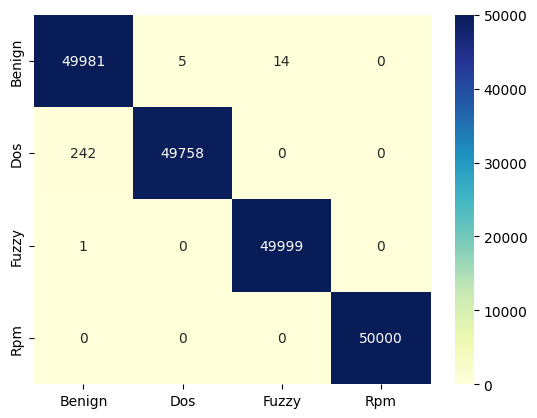

In [ ]:
import seaborn
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Benign', 'Dos', 'Fuzzy','Rpm'],
                                 index=['Benign', 'Dos', 'Fuzzy','Rpm'])

seaborn.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
import time
import numpy as np

start_time = time.time()
importances = grid.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in grid.best_estimator_.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.009 seconds


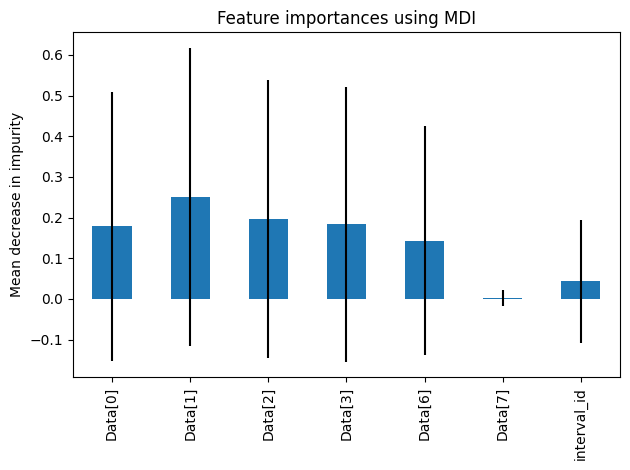

In [ ]:
import pandas as pd

forest_importances = pd.Series(importances, index=['Data[0]','Data[1]','Data[2]','Data[3]', 'Data[6]','Data[7]','interval_id'])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    grid.best_estimator_, encoded_X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=['Data[0]','Data[1]','Data[2]','Data[3]', 'Data[6]','Data[7]','interval_id'])

Elapsed time to compute the importances: 156.904 seconds


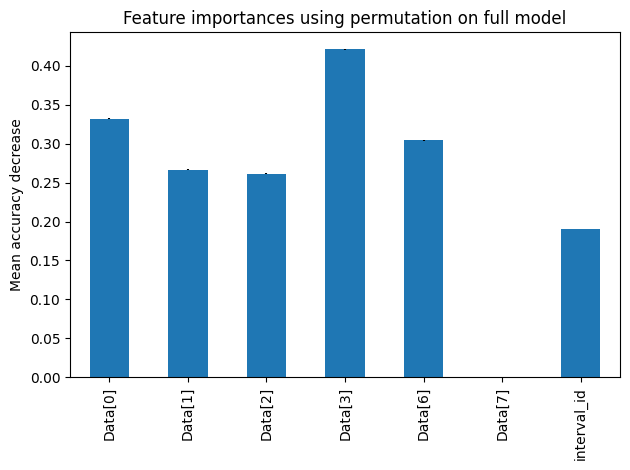

In [ ]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()